In [2]:
%pylab inline
import pickle
#import numpy as np
import os
import DifferentiableHOS as DHOS
import tensorflow as tf
from scipy import ndimage, misc
import jax
import jax_cosmo as jc

Populating the interactive namespace from numpy and matplotlib


In [3]:
field_size=5.
field_npix=1024
pix_scale = 5/1024*60# arcmin
sigma_pix=1/pix_scale

In [4]:
#Loads the jacobians computed from maps without smoothing and noise
ps_jac = []
for filename in os.listdir("/global/cscratch1/sd/dlan/jacobian_ps_pure_maps/jac"):
        res =pickle.load(open(os.path.join('/global/cscratch1/sd/dlan/jacobian_ps_pure_maps/jac', filename), 'rb'))
        ps_jac.append(res['jac_ps'])

In [5]:
ps_jac= stack(ps_jac, axis=0)

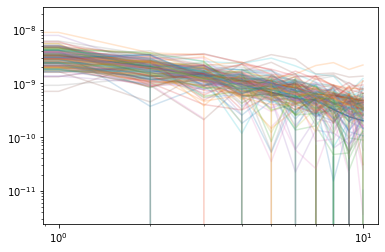

In [6]:
loglog(ps_jac.mean(axis=0))
for i in range(len(ps_jac)):
    loglog(ps_jac[i], alpha=0.2)

In [7]:
mu_jac = ps_jac.mean(axis=0)

In [8]:
# Load maps 
kmaps = []
for filename in os.listdir("/global/cscratch1/sd/dlan/maps/maps"):
        res =pickle.load(open(os.path.join('/global/cscratch1/sd/dlan/maps/maps', filename), 'rb'))
        kmaps.append(res['kmap'])

In [9]:
def rebin(a, shape):
    sh = shape, a.shape[0] // shape
    return tf.math.reduce_mean(tf.reshape(a, sh), axis=-1)

In [10]:
import jax.numpy as jnp
def rebin_jax(a, shape):
    a=jnp.array(a)
    sh = shape, a.shape[0] // shape
    return jnp.mean(jnp.reshape(a, sh),axis=-1)#a.reshape(sh).mean(-1)

In [11]:
# Compute power spectrum
ps_maps=[]
for m in kmaps:
        l, power_spectrum = DHOS.statistics.power_spectrum(m[0], field_size,field_npix)
        # Keep only ell between 300 and 3000
        ell = l[2:46]
        power_spectrum = power_spectrum[2:46]
        # Further reducing the nnumber of points
        ell = rebin(ell, 11)
        power_spectrum = rebin(power_spectrum, 11)
        ps_maps.append(power_spectrum)
        

In [12]:
ps_maps=stack(ps_maps, axis=0)
mu_ps_maps = ps_maps.mean(axis=0)

In [13]:

z_source = np.array([1.])
cosmo=jc.Planck15()
nz =jc.redshift.delta_nz(z_source)
probes = [jc.probes.WeakLensing([nz])] 
cls = jc.angular_cl.angular_cl(cosmo, l.numpy(), probes)


/global/homes/d/dlan/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5293: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [14]:
ps_halofit=cls[0]
ps_halofit = ps_halofit[2:46]
# Further reducing the nnumber of points
ps_halofit = rebin(ps_halofit, 11)

In [15]:
ll, power_spectrum = DHOS.statistics.power_spectrum(m[0], field_size,field_npix)

In [16]:

def mean_fn(p):
  cosmo = jc.Planck15(Omega_c=p[0], sigma8=p[1])
  # Compute signal vector
  m = jc.angular_cl.angular_cl(cosmo, ll.numpy(), probes)
  m = m[0][2:46]
  m = rebin_jax(m, 11)
  return m.flatten()
jac_mean = jax.jit(jax.jacfwd(mean_fn))
params = np.array([cosmo.Omega_c, cosmo.sigma8]) 
dmu = jac_mean(params)

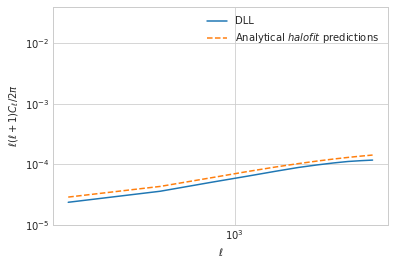

In [17]:
l=ell
style.use('seaborn-whitegrid')
loglog(l, l*(l+1)*mu_ps_maps/(2*np.pi),label='DLL')
loglog(l, l*(l+1)*ps_halofit/(2*np.pi),'--',label='Analytical $halofit$ predictions')
ylim(1e-5,4e-2)
ylabel('$\ell(\ell+1)C_\ell /2\pi$')
xlabel('$\ell$')
legend()

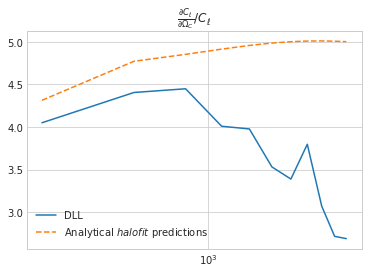

In [18]:
plt.semilogx(l,mu_jac[...,0]/mu_ps_maps,label='DLL')
plt.semilogx(l,dmu[...,0]/ps_halofit,'--',label='Analytical $halofit$ predictions')
title('$\\frac{\partial C_{\ell}}{ \partial \Omega_C}/C_{\ell}$')
savefig('psomeg.png',dpi=250)
legend()

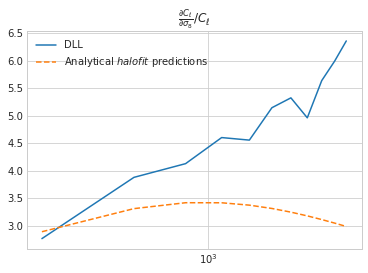

In [19]:
plt.semilogx(l,mu_jac[...,1]/mu_ps_maps,label='DLL')
plt.semilogx(l,dmu[...,1]/ps_halofit,'--',label='Analytical $halofit$ predictions')
title('$\\frac{\partial C_{\ell}}{ \partial \sigma_8}/C_{\ell} $')
savefig('pssigma.png',dpi=250)
legend()

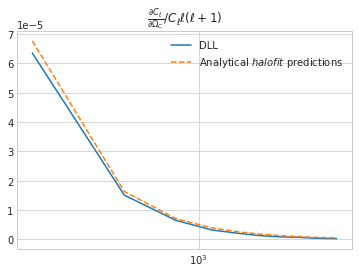

In [19]:
plt.semilogx(l,mu_jac[...,0]/(mu_ps_maps*l*(l+1)),label='DLL')
plt.semilogx(l,dmu[...,0]/(ps_halofit*l*(l+1)),'--',label='Analytical $halofit$ predictions')
title('$\\frac{\partial C_{\ell}}{ \partial \Omega_C}/C_{\ell} \ell(\ell+1)$')
legend()

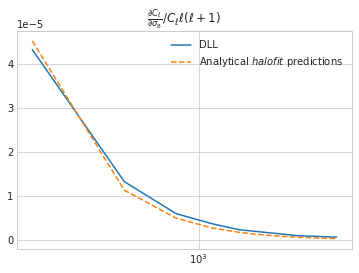

In [20]:
plt.semilogx(l,mu_jac[...,1]/(mu_ps_maps*l*(l+1)),label='DLL')
plt.semilogx(l,dmu[...,1]/(ps_halofit*l*(l+1)),'--',label='Analytical $halofit$ predictions')
title('$\\frac{\partial C_{\ell}}{ \partial \sigma_8}/C_{\ell} \ell(\ell+1) $')
legend()